## Testing

In [1]:
import sys
import os

sys.path.append(os.getcwd())
import numpy as np
import os
import io
import cv2

import torch

from demo.config import (Config,
                    eval_dict_leaf)

from demo.utils import *

from iv2_utils.iv2 import *
from models import *

/home/zli/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-07-20 17:33:33,498] [INFO] [real_accelerator.py:239:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
from huggingface_hub import hf_hub_download
from collections import OrderedDict
from utils.basic_utils import *
from easydict import EasyDict as edict

args = edict(
    hf_repo='qingy2024/InternVideo2-B14',
    config_dir="scripts/spfs/clip/B14/"
)

device = torch.device('cuda')

print("Downloading Mamba checkpoint from Hugging Face Hub...")
mamba_checkpoint_path = hf_hub_download(repo_id=args.hf_repo, filename="mamba_mobileclip_ckpt.pt")
print(f"Downloaded Mamba checkpoint to {mamba_checkpoint_path}")

print("Downloading SPFS checkpoint from Hugging Face Hub...")
spfs_checkpoint_path = hf_hub_download(repo_id=args.hf_repo, filename="spfs_ckpt.pt")
print(f"Downloaded SPFS checkpoint to {spfs_checkpoint_path}")

mamba_ckpt = torch.load(mamba_checkpoint_path, map_location=device)
processed_mamba = process_state_dict(mamba_ckpt)

spfs_ckpt = torch.load(spfs_checkpoint_path, map_location=device, weights_only = False)
processed_spfs = process_state_dict(spfs_ckpt)

merged_state_dict = merge_state_dicts([processed_mamba, processed_spfs], override=True)

Downloaded Mamba checkpoint to /home/zli/.cache/huggingface/hub/models--qingy2024--InternVideo2-B14/snapshots/d8253b6940aeb437e2f1e073655ca35624cf5f08/mamba_mobileclip_ckpt.pt
Downloaded SPFS checkpoint to /home/zli/.cache/huggingface/hub/models--qingy2024--InternVideo2-B14/snapshots/d8253b6940aeb437e2f1e073655ca35624cf5f08/spfs_ckpt.pt


In [3]:
ckpt_keys = list(merged_state_dict.keys())

In [4]:
spfs_ckpt['model'].keys()

odict_keys(['temp', 'streaming_vision_encoder.vit_lite.patch_emb.0.block.norm.running_mean', 'streaming_vision_encoder.vit_lite.patch_emb.0.block.norm.running_var', 'streaming_vision_encoder.vit_lite.patch_emb.0.block.norm.num_batches_tracked', 'streaming_vision_encoder.vit_lite.patch_emb.1.block.norm.running_mean', 'streaming_vision_encoder.vit_lite.patch_emb.1.block.norm.running_var', 'streaming_vision_encoder.vit_lite.patch_emb.1.block.norm.num_batches_tracked', 'streaming_vision_encoder.rnn.pred_U', 'streaming_vision_encoder.rnn.pred_V.weight', 'streaming_vision_encoder.rnn.logvar.weight', 'streaming_vision_encoder.rnn.logvar.bias', 'streaming_vision_encoder.output_fc.0.weight', 'streaming_vision_encoder.output_fc.0.bias', 'streaming_vision_encoder.output_fc.2.weight', 'streaming_vision_encoder.output_fc.2.bias'])

In [5]:
config = Config.from_file(os.path.join(args.config_dir, "config.py"))

config = eval_dict_leaf(config)

# Set rnn_type to mamba_spfs
config.model.streaming_vision_encoder.rnn_type = 'mamba_spfs'

intern_model = InternVideo2_CLIP_small(config)
intern_model.to(device)

InternVideo2_CLIP_small(
  (tokenizer): ClipTokenizer()
  (vision_encoder): InternVideo2(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(3, 768, kernel_size=(1, 14, 14), stride=(1, 14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): RMSNorm()
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=False)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
          (q_norm): RMSNorm()
          (k_norm): RMSNorm()
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): RMSNorm()
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (drop1): Dropout(p=0.0, inplace=False)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
        

In [6]:
for n, p in intern_model.named_parameters():
    if n not in ckpt_keys:
        print(n)

In [7]:
video_path = 'sunset.mp4'#'photography-model/data/act75/1.mp4'

In [10]:
from cv2 import VideoCapture
from demo.utils import _frame_from_video

frames = [x for x in _frame_from_video(VideoCapture(video_path))]

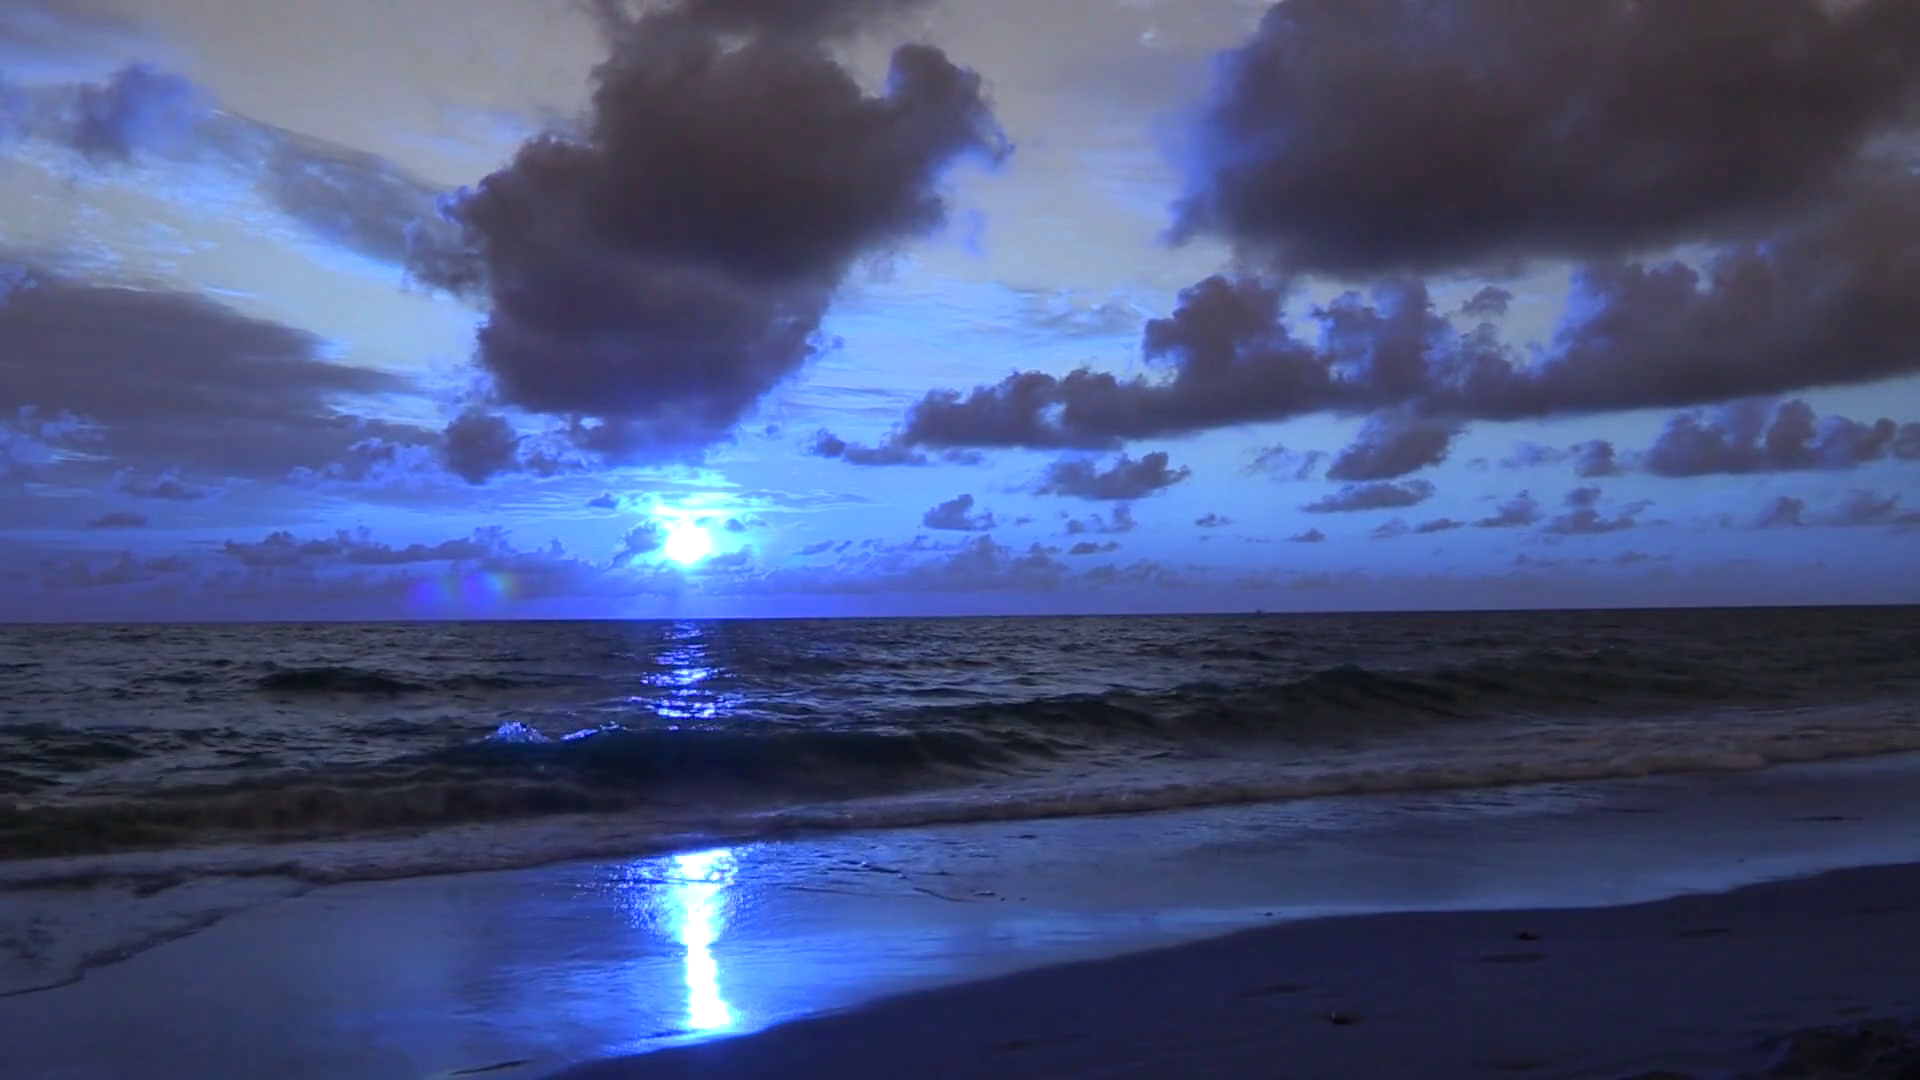

In [11]:
import PIL
from PIL import Image

Image.fromarray(frames[81])

In [12]:
frame_tensor = frames2tensor([frames[75]], fnum=1, target_size=(224,224), device=device)

frame_tensor.shape

torch.Size([1, 1, 3, 224, 224])

In [13]:
frame_embed = intern_model.get_vid_feat(frame_tensor)

In [14]:
frame_embed.shape

torch.Size([1, 512])

In [15]:
text_embed = intern_model.get_txt_feat('A person splashing and make big splash in water')

text_embed.shape

torch.Size([1, 512])

In [16]:
from torch.nn import functional as F

F.cosine_similarity(frame_embed, text_embed)

tensor([0.0636], device='cuda:0')

In [17]:
_, _ = intern_model.load_state_dict(merged_state_dict, strict=False)

In [18]:
hidden = intern_model.streaming_vision_encoder.init_hidden(batch_size=1, device=device)
for frame in range(50, 100):
    frame_tensor = frames2tensor([frames[frame]], fnum=1, target_size=(224,224), device=device)

    embed, hidden, spfs_info = intern_model.streaming_vision_encoder(frame_tensor.squeeze(0), prev_hidden_state = hidden, confidence_threshold = 0.9, max_consecutive_skips=6)

    embed = intern_model.vision_align(embed)

    print(f"Embedding Sim: {F.cosine_similarity(embed, frame_embed)}")
    print(f"SPFS Info: {spfs_info}")

Embedding Sim: tensor([0.8654], device='cuda:0', grad_fn=<SumBackward1>)
SPFS Info: {'skipped': False, 'confidence': 0.0}
Embedding Sim: tensor([0.8674], device='cuda:0', grad_fn=<SumBackward1>)
SPFS Info: {'skipped': False, 'confidence': 0.6795917749404907, 'gt_cos': 0.06861169636249542}
Embedding Sim: tensor([0.8888], device='cuda:0', grad_fn=<SumBackward1>)
SPFS Info: {'skipped': False, 'confidence': 0.8200985789299011, 'gt_cos': 0.03453965485095978}
Embedding Sim: tensor([0.8847], device='cuda:0', grad_fn=<SumBackward1>)
SPFS Info: {'skipped': False, 'confidence': 0.7119203805923462, 'gt_cos': 0.07381944358348846}
Embedding Sim: tensor([0.8860], device='cuda:0', grad_fn=<SumBackward1>)
SPFS Info: {'skipped': False, 'confidence': 0.5144773125648499, 'gt_cos': 0.09317045658826828}
Embedding Sim: tensor([0.8858], device='cuda:0', grad_fn=<SumBackward1>)
SPFS Info: {'skipped': False, 'confidence': 0.5190503001213074, 'gt_cos': 0.09922751784324646}
Embedding Sim: tensor([0.8838], device

In [138]:
a.shape

torch.Size([1, 768])

In [143]:
c

{'skipped': False, 'confidence': 0.0}

## Normalized

In [43]:
"""
Single-file demo for InternVideo2-B14 with SPFS
------------------------------------------------
1. Downloads ONE checkpoint file: ckpt_step_12500.pt
2. Loads the whole model in one line
3. Processes a video with SPFS after an 8-frame warm-up
"""
import os
import sys
from pathlib import Path

import torch
from easydict import EasyDict as edict
from huggingface_hub import hf_hub_download
from cv2 import VideoCapture

# ------------------------------------------------------------------
# local imports
# ------------------------------------------------------------------
sys.path.append(os.getcwd())

from demo.config import Config, eval_dict_leaf
from demo.utils import _frame_from_video, frames2tensor
from dataset import get_train_transform
from models import InternVideo2_CLIP_small

# ------------------------------------------------------------------
# config
# ------------------------------------------------------------------
args = edict(
    hf_repo='qingy2024/InternVideo2-B14',
    config_dir="scripts/spfs/clip/B14/",
    video_path='photography-model/data/act75/1.mp4',
    device='cuda' if torch.cuda.is_available() else 'cpu',
    seed=42,
)

device = torch.device(args.device)

# ------------------------------------------------------------------
# helper: load model & checkpoint
# ------------------------------------------------------------------
def build_model(config_dir: str, ckpt_path: str, device: torch.device):
    """Build model and load full checkpoint"""
    config = Config.from_file(os.path.join(config_dir, "config.py"))
    config = eval_dict_leaf(config)
    config.model.streaming_vision_encoder.rnn_type = 'mamba_spfs'

    model = InternVideo2_CLIP_small(config).to(device)
    ckpt = torch.load(ckpt_path, map_location=device, weights_only=False)['model']
    a, b = model.load_state_dict(ckpt, strict=False)
    model.eval()
    return model


# ------------------------------------------------------------------
# helper: video handling
# ------------------------------------------------------------------
def load_video_frames(video_path: str):
    """Return list of PIL images (RGB)"""
    cap = VideoCapture(video_path)
    return [img for img in _frame_from_video(cap)]


# ------------------------------------------------------------------
# main
# ------------------------------------------------------------------
def main(confidence_threshold = 0.9, max_consecutive_skips = 6,):
    # 1. download single checkpoint
    ckpt_path = hf_hub_download(repo_id=args.hf_repo, filename="spfs_r64/ckpt_step_22500.pt")
    print(f"Downloaded checkpoint to {ckpt_path}")

    # 2. build model
    model = build_model(args.config_dir, ckpt_path, device)

    # 3. load video
    frames = load_video_frames(args.video_path)
    print(f"Loaded {len(frames)} frames from {args.video_path}")

    # 4. warm-up: process first 8 frames without skipping
    hidden = model.streaming_vision_encoder.init_hidden(batch_size=1, device=device)
    for i in range(8):
        x = frames2tensor([frames[i]], fnum=1, target_size=(224, 224), device=device)
        x = x.permute(0, 2, 1, 3, 4)
        with torch.no_grad():
            _, hidden, _ = model.streaming_vision_encoder(
                x,
                prev_hidden_state=hidden,
                confidence_threshold=1.0,
                max_consecutive_skips=0,
            )
    print("Warm-up phase completed.")

    skipped_frames = 0
    
    # 5. main loop with SPFS
    for idx in range(8, len(frames)):
        x = frames2tensor([frames[idx]], fnum=1, target_size=(224, 224), device=device)
        x = x.permute(0, 2, 1, 3, 4)
        
        with torch.no_grad():
            _, hidden, spfs_info = model.streaming_vision_encoder(
                x,
                prev_hidden_state=hidden,
                confidence_threshold=confidence_threshold,
                max_consecutive_skips=max_consecutive_skips,
            )
    
        if idx % 10 == 0:
            print(f"SPFS Info: {spfs_info}")

        if spfs_info.confidence > confidence_threshold:
            skipped_frames += 1

    print(f"Total Skipped Frames: {skipped_frames}/{len(frames)} ({skipped_frames/len(frames) * 100:.2f}%)")

if __name__ == "__main__":
    main(
        confidence_threshold = 0.85,
        max_consecutive_skips = 5,
    )

Downloaded checkpoint to /home/zli/.cache/huggingface/hub/models--qingy2024--InternVideo2-B14/snapshots/64d54e5a66639f03b30d640b63310d8cf63af452/spfs_r64/ckpt_step_22500.pt
Loaded 192 frames from photography-model/data/act75/1.mp4
Warm-up phase completed.
SPFS Info: {'skipped': True, 'confidence': 0.8795495629310608, 'gt_cos': 0.7868853211402893}
SPFS Info: {'skipped': True, 'confidence': 0.8761847019195557, 'gt_cos': 0.8060997724533081}
SPFS Info: {'skipped': True, 'confidence': 0.9150826334953308, 'gt_cos': 0.7319422960281372}
SPFS Info: {'skipped': True, 'confidence': 0.9162728190422058, 'gt_cos': 0.7889687418937683}
SPFS Info: {'skipped': True, 'confidence': 0.9204827547073364, 'gt_cos': 0.8600692749023438}
SPFS Info: {'skipped': True, 'confidence': 0.9353339672088623, 'gt_cos': 0.7732146978378296}
SPFS Info: {'skipped': True, 'confidence': 0.9358277916908264, 'gt_cos': 0.8126603960990906}
SPFS Info: {'skipped': True, 'confidence': 0.9009456634521484, 'gt_cos': 0.8173682689666748}


In [16]:
from dataset import get_train_transform

In [20]:
transform = get_train_transform(config, '')

In [3]:
processed_predictor.keys()

odict_keys(['temp', 'streaming_vision_encoder.vit_lite.patch_emb.0.block.norm.running_mean', 'streaming_vision_encoder.vit_lite.patch_emb.0.block.norm.running_var', 'streaming_vision_encoder.vit_lite.patch_emb.0.block.norm.num_batches_tracked', 'streaming_vision_encoder.vit_lite.patch_emb.1.block.norm.running_mean', 'streaming_vision_encoder.vit_lite.patch_emb.1.block.norm.running_var', 'streaming_vision_encoder.vit_lite.patch_emb.1.block.norm.num_batches_tracked', 'streaming_vision_encoder.rnn.pred_U', 'streaming_vision_encoder.rnn.pred_V.weight', 'streaming_vision_encoder.output_fc.0.weight', 'streaming_vision_encoder.output_fc.0.bias', 'streaming_vision_encoder.output_fc.2.weight', 'streaming_vision_encoder.output_fc.2.bias'])

In [4]:
processed_confidence.keys()

odict_keys(['temp', 'streaming_vision_encoder.vit_lite.patch_emb.0.block.norm.running_mean', 'streaming_vision_encoder.vit_lite.patch_emb.0.block.norm.running_var', 'streaming_vision_encoder.vit_lite.patch_emb.0.block.norm.num_batches_tracked', 'streaming_vision_encoder.vit_lite.patch_emb.1.block.norm.running_mean', 'streaming_vision_encoder.vit_lite.patch_emb.1.block.norm.running_var', 'streaming_vision_encoder.vit_lite.patch_emb.1.block.norm.num_batches_tracked', 'streaming_vision_encoder.rnn.logvar.weight', 'streaming_vision_encoder.rnn.logvar.bias', 'streaming_vision_encoder.output_fc.0.weight', 'streaming_vision_encoder.output_fc.0.bias', 'streaming_vision_encoder.output_fc.2.weight', 'streaming_vision_encoder.output_fc.2.bias'])